In [1]:
import os
from sklearn.model_selection import StratifiedKFold, train_test_split
from torch.utils.data import TensorDataset, DataLoader
from skimage.io import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from albumentations.pytorch import ToTensorV2
from six.moves import xrange
import random
import umap
import cv2 as cv
import natsort
from tqdm import tqdm
from prefetch_generator import BackgroundGenerator
import utils_test
from skimage.transform import resize
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import read_data

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import pandas as pd
from sklearn.model_selection import StratifiedKFold,ShuffleSplit,KFold
import nibabel as nib
import pickle
import copy
# import preprocessing
# import utils
import nets_LV
from collections import namedtuple
# from utils import img_extended
import albumentations as A
from sklearn import metrics
import itertools
import resample_function as resample
import math       

from sklearn.metrics import roc_curve, precision_recall_curve, auc,average_precision_score,roc_auc_score
from sklearn.preprocessing import label_binarize

In [2]:
idx_to_label = {0: 'non-DR', 1: 'NPDR', 2: 'PDR'}


def getKey(item):
    for idx, label in idx_to_label.items():
        if label == item:
            return idx

        

def getValue(key):
    for idx, label in idx_to_label.items():
        if idx == key:
            return label


In [3]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

#         albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=(-20,20), shift_limit=0.1, p=1, border_mode=0),


        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albu.RandomResizedCrop(height=512, width=512, scale=(0.80, 1), always_apply=True),

        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),


        # albu.RandomBrightness(limit=0.4),
        # albu.RandomContrast(limit=0.4),


        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
#                 albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

#         albu.OneOf(
#             [
#                 albu.RandomContrast(p=1),
#                 albu.HueSaturationValue(p=1),
#             ],
#             p=0.9,
#         ),
    ]
    return albu.Compose(train_transform)

In [4]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.Resize(512,512)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


In [5]:
class anomalyDetectionB5(Dataset):
    def __init__(self, images,labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform


    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        image = self.images[idx]
        image = (image).astype('uint8')
        label = self.labels[idx]

#         image = image/255
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return (image/255), label

In [6]:
params = {
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 4,
    "num_workers": 4,
    "epochs": 200,
}


In [7]:



data =[]
label = []
filenames = []
ctlist=os.listdir('/home/hana/optima/exchange/hjebril/challenge/C. Diabetic Retinopathy Grading/1. Original Images/Training Set_cropped_deleted')
ctlist=natsort.natsorted(ctlist)
# read labels from the excel file
dfs_classification = pd.read_csv('/home/hana/optima/exchange/hjebril/challenge/C. Diabetic Retinopathy Grading/2. Groundtruths/a. DRAC2022_ Diabetic Retinopathy Grading_Training Labels.csv')
dfs_quality = pd.read_csv('/home/hana/optima/exchange/hjebril/challenge/B. Image Quality Assessment/2. Groundtruths/a. DRAC2022_ Image Quality Assessment_Training Labels.csv')

for idx, filename in enumerate(ctlist):
    x_classification = dfs_classification.loc[dfs_classification['image name'] == filename]['DR grade'].values
    x_qulity = dfs_quality.loc[dfs_quality['image name'] == filename]['image quality level'].values
#     if(x_classification[0] == 0):
    if(x_qulity[0] == 2):
        image = imread('/home/hana/optima/exchange/hjebril/challenge/C. Diabetic Retinopathy Grading/1. Original Images/Training Set_cropped_deleted/'+filename)
#         image = cv.resize(image, (512, 512))
        if(image.shape[0]>608):
            image = cv.resize(image, (608, 608))
        data.append(image)
        label.append(x_classification[0])
        filenames.append(filename)


In [8]:
data = np.asarray(data)
label = np.asarray(label)
filenames = np.asarray(filenames)

In [9]:
my_whole_seed = 42
torch.manual_seed(my_whole_seed)
torch.cuda.manual_seed_all(my_whole_seed)
torch.cuda.manual_seed(my_whole_seed)
np.random.seed(my_whole_seed)
random.seed(my_whole_seed)

In [10]:
normal_data= data[np.where(label == 0)[0]]
anomolous_data= data[np.where(label != 0)[0]]
normal_label = label[np.where(label == 0)[0]]
anomolous_label = label[np.where(label != 0)[0]]
normal_filenames = filenames[np.where(label == 0)[0]]
anomolous_filenames = filenames[np.where(label != 0)[0]]
roc_list = []
kfold2 = ShuffleSplit(n_splits=7, random_state=0, train_size=0.8)
for train_ix, test_ix in kfold2.split(normal_data,normal_label):
    # select rows
    X_train, X_rem = normal_data[train_ix], normal_data[test_ix]
    y_train, y_rem = normal_label[train_ix], normal_label[test_ix]
    filenames_train, filenames_rem = normal_filenames[train_ix], normal_filenames[test_ix]
    kfold1 = ShuffleSplit(n_splits=6, random_state=0, test_size=0.5)
    for valid_ix, test_ix in kfold1.split(X_rem,y_rem):
        # select rows
        X_valid1, X_test1 = X_rem[valid_ix], X_rem[test_ix]
        y_valid1, y_test1 = y_rem[valid_ix], y_rem[test_ix]
        filenames_valid1, filenames_test1 = filenames_rem[valid_ix], filenames_rem[test_ix] 
        kf = StratifiedKFold(n_splits=2, shuffle=True)
        for train_idx, test_idx in kf.split(anomolous_data,anomolous_label):
            X_test2, X_valid2 = anomolous_data[train_idx], anomolous_data[test_idx]
            y_test2, y_valid2 = anomolous_label[train_idx], anomolous_label[test_idx]
            filenames_test2, filenames_valid2 = anomolous_filenames[train_idx], anomolous_filenames[test_idx]
            X_valid = np.concatenate((X_valid2, X_valid1), axis=0)
            X_test = np.concatenate((X_test2, X_test1), axis=0)
            y_valid = np.concatenate((y_valid2, y_valid1), axis=0)
            y_test = np.concatenate((y_test2, y_test1), axis=0)    
            filenames_valid = np.concatenate((filenames_valid2, filenames_valid1), axis=0)
            filenames_test = np.concatenate((filenames_test2, filenames_test1), axis=0)  

In [11]:
train_dataset = anomalyDetectionB5(images=X_train,labels = y_train, transform=get_training_augmentation())
valid_dataset = anomalyDetectionB5(images=X_valid,labels = y_valid, transform=get_validation_augmentation())
test_dataset = anomalyDetectionB5(images=X_test,labels = y_test, transform=get_validation_augmentation())

train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    valid_dataset, batch_size=1, shuffle=False , num_workers=params["num_workers"], pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False , num_workers=params["num_workers"], pin_memory=True,
)
device = torch.device(params["device"])


In [12]:
saveroot = 'earlyStop'


feat_ext_mdl = nets_LV.VQVAE(1,n_channels=(16,32,64,128),code_size=128,n_res_block=2, dropout_p=.1)
device= "cuda"
feat_ext_mdl.to(device)

bestmodelpath = os.path.join(saveroot, 'vqvae',
                             natsort.natsorted(os.listdir(os.path.join(saveroot, 'vqvae')))[-1])
# restore_path = os.path.join(saveroot, 'best_model',
#                             natsort.natsorted(os.listdir(os.path.join(saveroot, 'best_model')))[-1]) + '/' + \
#                os.listdir(bestmodelpath)[0]

print('bestmodelpath',bestmodelpath)
feat_ext_mdl.load_state_dict(
    torch.load(bestmodelpath)['model']
)
    
    
# chpt = torch.load('saved_model/vqvae_200.pt')
# feat_ext_mdl.load_state_dict(chpt['model'])


model = nets_LV.VQLatentSNAIL(feature_extractor_model=feat_ext_mdl,
                              shape=(64,64), n_block = 4, n_res_block = 4, n_channels = 128)
model.to(device)
# chpt = torch.load('saved_model/AR_300.pt')
# model.load_state_dict(chpt['model'])

bestmodelpath = os.path.join(saveroot, 'AR',
                             natsort.natsorted(os.listdir(os.path.join(saveroot, 'AR')))[-1])
# restore_path = os.path.join(saveroot, 'best_model',
#                             natsort.natsorted(os.listdir(os.path.join(saveroot, 'best_model')))[-1]) + '/' + \
#                os.listdir(bestmodelpath)[0]

print('bestmodelpath',bestmodelpath)
model.load_state_dict(
    torch.load(bestmodelpath)['model']
)


bestmodelpath earlyStop/vqvae/checkpoints_earlystop_188.pt
bestmodelpath earlyStop/AR/checkpoints_earlystop_284.pt


<All keys matched successfully>

In [13]:
def evaluate_vqvae(net,dataloader,device,nb_forward=15):
    net.eval()
    losses = torch.empty((0,64,64))
    probs_list = []
    # iterate over the validation set
    # for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
    pbar = tqdm(enumerate(BackgroundGenerator(dataloader)), total=len(dataloader))
    for itr, (test_images, test_annotations) in pbar:
        x = test_images
        # move images and labels to correct device and type
        x = x.to(device=device, dtype=torch.float32)

        # iterate over the forward passes
#         for f_pass in range(nb_forward):
        with torch.no_grad():
            # predict the mask (pytorch tensor have the following structure : [batch_no, class, pixel_x, pixel_y])
#             codes = net.retrieve_codes(x)
#             logits = model.forward_latent(codes)
            # take probability
#             probs = F.softmax(logits, dim=1)
#             loss1 = F.cross_entropy(logits, codes, reduction='none')
#             probs = F.softmax(loss1, dim=1)
            result = net.loss(x, reduction='none')
            loss = result['loss']
            probs = F.softmax(loss, dim=1)
            losses = torch.cat((losses,loss.cpu()),dim=0)
              # upscale loss
            up_scl = 8
            upscale_loss = np.kron(loss.cpu().numpy()[0], np.ones((up_scl,up_scl)))
            probs_list.append(upscale_loss)
#                 plt.imshow(result['x_tilde'].cpu().numpy()[0][0])
#                 plt.show()
#                 cv2.imwrite(os.path.join(test_results_visulaize, cubename[0]),mask_pred_softmax[0,1].cpu().detach().numpy()*255)
    return np.array(probs_list)




In [14]:
losses = evaluate_vqvae(model,val_loader,device,nb_forward=15)

100%|██████████| 145/145 [00:16<00:00,  8.74it/s]


In [15]:
perces = []
perces.append(np.percentile(losses, 99))
perces.append(np.percentile(losses, 98))
perces.append(np.percentile(losses, 97))
perces.append(np.percentile(losses, 96))
perces.append(np.percentile(losses, 95))
perces.append(np.percentile(losses, 94))
perces.append(np.percentile(losses, 93))
perces.append(np.percentile(losses, 92))
perces.append(np.percentile(losses, 91))
perces.append(np.percentile(losses, 90))
perces.append(np.percentile(losses, 89))
perces.append(np.percentile(losses, 88))


In [16]:
perces

[7.2206950187683105,
 6.6641740798950195,
 6.340746879577637,
 6.110380172729492,
 5.932365393638527,
 5.787481307983398,
 5.665168762207031,
 5.558424949645996,
 5.464435577392578,
 5.382349061965964,
 5.306325912475586,
 5.236539840698242]

In [17]:
def roc_auc_img(gt, score):
    img_roc_auc = roc_auc_score(gt, score)
    
    return img_roc_auc


def cal_img_roc(scores, gt_list):
    img_scores = scores.reshape(scores.shape[0], -1)
#     img_scores = scores.reshape(scores.shape[0], -1).sum(axis=1)
#     print(img_scores)
    gt_list = np.asarray(gt_list)
    fpr, tpr, _ = roc_curve(gt_list, img_scores)
    img_roc_auc = roc_auc_img(gt_list, img_scores)

    return fpr, tpr, img_roc_auc

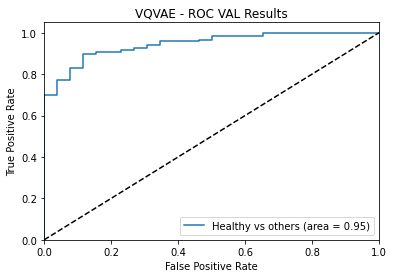

5.5
0.945054945054945


In [18]:


from sklearn import metrics
with torch.no_grad():
#     codes = model.retrieve_codes(x/255)
#     loss = model.loss(x/255, reduction='none')['loss']
    
    mood_test = []
    label_test = []
    for img, label in val_loader:
        mood_test.append(img)
        label_test.append(label.item())
    
    label_test = np.array(label_test)
    
# for thresh in perces:    
thresh = 5.5
pred = []
all_pred_tensor_val = torch.empty((0, 1), dtype=torch.float32).to('cuda')
model.eval()
for X in mood_test:
    x_img = X.to(device).float()
    with torch.no_grad():
        codes = model.retrieve_codes(x_img).flatten(1)
        loss = model.loss(x_img, reduction='none')['loss'].flatten(1)
        score1 = torch.sum(loss*(loss>thresh),1).float()
        score1 = score1.unsqueeze(1)
#         score1 = torch.softmax(score1)
        all_pred_tensor_val = torch.cat((all_pred_tensor_val, score1), 0)
# pred = np.concatenate(pred,1).reshape(-1,1)

y_valid_2 = np.where(y_valid > 0, 1, 0)

fpr, tpr, img_roc_auc = cal_img_roc(all_pred_tensor_val.cpu(), y_valid_2)
plt.plot(fpr, tpr, label='Healthy vs others (area = {0:0.2f})'
                                       ''.format(img_roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# label ='AVG ROC = {0:0.2f}'''.format(totl_roc/3)
plt.title('VQVAE - ROC VAL Results')
plt.legend(loc="lower right")
plt.show()
print(thresh)
print(img_roc_auc)

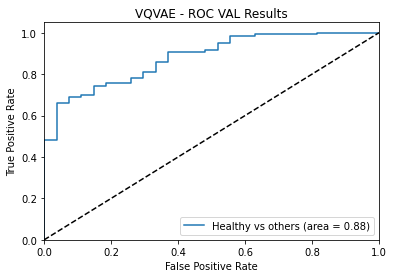

5.5
0.8799382716049383


In [20]:


from sklearn import metrics
with torch.no_grad():
#     codes = model.retrieve_codes(x/255)
#     loss = model.loss(x/255, reduction='none')['loss']
    
    mood_test = []
    label_test = []
    for img, label in test_loader:
        mood_test.append(img)
        label_test.append(label.item())
    
    label_test = np.array(label_test)
    
# for thresh in perces:    
thresh = 5.5
pred = []
all_pred_tensor_test = torch.empty((0, 1), dtype=torch.float32).to('cuda')
model.eval()
for X in mood_test:
    x_img = X.to(device).float()
    with torch.no_grad():
        codes = model.retrieve_codes(x_img).flatten(1)
        loss = model.loss(x_img, reduction='none')['loss'].flatten(1)
        score1 = torch.sum(loss*(loss>thresh),1).float()
        score1 = score1.unsqueeze(1)
#         score1 = torch.softmax(score1)
        all_pred_tensor_test = torch.cat((all_pred_tensor_test, score1), 0)
# pred = np.concatenate(pred,1).reshape(-1,1)


y_test_2 = np.where(y_test > 0, 1, 0)

fpr_vq, tpr_vq, img_roc_auc_vq = cal_img_roc(all_pred_tensor_test.cpu(), y_test_2)
plt.plot(fpr_vq, tpr_vq, label='Healthy vs others (area = {0:0.2f})'
                                       ''.format(img_roc_auc_vq))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# label ='AVG ROC = {0:0.2f}'''.format(totl_roc/3)
plt.title('VQVAE - ROC VAL Results')
plt.legend(loc="lower right")
plt.show()
print(thresh)
print(img_roc_auc)

In [49]:


# np.save('pred_vqvae_drac.npy',all_pred_tensor_test.cpu())
# np.save('y_test_2_VQVAE.npy',y_test_2)

### uncertainty

In [21]:
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()
            #logging.info("activated dropout")



In [27]:
def evaluate_uncertainty(net,
                        dataloader,
                        device,
                        nb_forward):
    net.eval()
    uncertaities = []
    #Activate the dropout layers
    enable_dropout(net)
#     test_results = os.path.join(opt.saveroot, 'test_results_drac_all')
#     test_results_visulaize = os.path.join(opt.saveroot, 'drac_output_all')
    #Define the bash number
    num_val_batches = len(dataloader)

    #Initialization of scores
    dice_score = 0
    n_classes = 2
    accuracy_score = 0
    accuracy_per_class = 0
    F1_coeff_per_class  = 0
    IOU_coeff = 0 
    IOU_coeff_per_class = 0
    cf_matrix = np.zeros(shape = (n_classes,n_classes))
    pa = 0
    pu = 0
    pavpu = 0

    # iterate over the validation set
    # for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
    pbar = tqdm(enumerate(BackgroundGenerator(dataloader)), total=len(dataloader))
    for itr, (test_images, label) in pbar:
        image = test_images.unsqueeze(1)
        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)
        dropout_predictions = torch.empty((0,1,2,512, 512))
        # iterate over the forward passes
        for f_pass in range(nb_forward):
            with torch.no_grad():
                # predict the mask (pytorch tensor have the following structure : [batch_no, class, pixel_x, pixel_y])
                mask_pred = net(image)
                mask_pred_softmax = mask_pred.cpu().softmax(dim=1)
#                 cv2.imwrite(os.path.join(test_results_visulaize, cubename[0]),mask_pred_softmax[0,1].cpu().detach().numpy()*255)
                # concatenate prediction to the other made on the same batch
                dropout_predictions = torch.cat((dropout_predictions,mask_pred.cpu().softmax(dim=1).unsqueeze(dim=0)),dim=0)

                # # compute confidence matrix
                # cf_matrix = cf_matrix + confusion_matrix(mask_true.argmax(dim=1).view(-1).cpu(),mask_pred.argmax(dim=1).view(-1).cpu(), labels = np.arange(0,n_classes))
        #Compute uncertainty indicateurs
        batch_mean = dropout_predictions.mean(dim=0)
#         str=cubename[0].split('.')[0]+'.npy'
        batch_std = dropout_predictions.std(dim=0)
        batch_pred_entropy = -torch.sum(batch_mean*batch_mean.log(),dim=1)
        batch_mutual_info = batch_pred_entropy+torch.mean(torch.sum(dropout_predictions*dropout_predictions.log(),dim=-3),dim=0)
        # cv2.imwrite(os.path.join(test_results, cubename[0]),batch_mutual_info[0,:,:].cpu().detach().numpy()*255)
#         np.save(os.path.join(test_results, str), batch_mutual_info[0,:,:].cpu().detach().numpy())
        uncertaities.append(batch_mutual_info[0,:,:].cpu().detach().numpy())
    
    uncertaities_np = np.array(uncertaities)
    return uncertaities_np



In [45]:
from models.unet import UNet
from options.test_options import TestOptions



net= UNet(in_channels=1, n_classes=2, channels=128);

saveroot = 'logs'
bestmodelpath = os.path.join(saveroot, 'best_model_drac',
                                 natsort.natsorted(os.listdir(os.path.join(saveroot, 'best_model_drac')))[-1])
restore_path = os.path.join(saveroot, 'best_model_drac',
                            natsort.natsorted(os.listdir(os.path.join(saveroot, 'best_model_drac')))[-1]) + '/' + \
               os.listdir(bestmodelpath)[0]
net.load_state_dict(
    torch.load(restore_path, map_location=device)
)
#input the model into GPU
net.to(device=device)

UNet(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.1, inplace=False)
    )
    (conv2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.1, inplace=False)
    )
    (conv3): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Dropout2d(p=0.1, inplace=False)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0)

In [46]:
uncertaities_np_valid = evaluate_uncertainty(net,val_loader,device, nb_forward=50)

100%|██████████| 145/145 [13:33<00:00,  5.61s/it]


In [47]:
uncertaities_np_test = evaluate_uncertainty(net,test_loader,device, nb_forward=50)

100%|██████████| 147/147 [15:04<00:00,  6.15s/it]


In [54]:
perces2 = []
perces2.append(np.percentile(uncertaities_np_test, 99.93))
perces2.append(np.percentile(uncertaities_np_test, 99.5))
perces2.append(np.percentile(uncertaities_np_test, 99))
perces2.append(np.percentile(uncertaities_np_test, 98))
perces2.append(np.percentile(uncertaities_np_test, 97))
perces2.append(np.percentile(uncertaities_np_test, 96))
perces2.append(np.percentile(uncertaities_np_test, 95))

In [55]:
perces2

[0.20112192454636446,
 0.1445378212630748,
 0.12608333349227863,
 0.1077097451686857,
 0.09645402431488037,
 0.08791828155517578,
 0.0807600565254688]

In [42]:
total_val = (uncertaities_np_valid*(uncertaities_np_valid > 0.11)).sum(axis = (1,2))

In [43]:
total_test = (uncertaities_np_test*(uncertaities_np_test > 0.11)).sum(axis = (1,2))

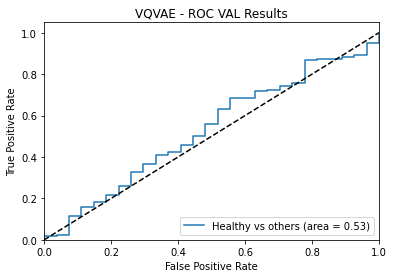

0.0807600565254688
0.8799382716049383


In [57]:


from sklearn import metrics
#     codes = model.retrieve_codes(x/255)
#     loss = model.loss(x/255, reduction='none')['loss']
    
mood_test = []
label_test2 = []
for img, label in test_loader:
    mood_test.append(img)
    label_test2.append(label.item())

label_test2 = np.array(label_test)
    

y_test_22 = np.where(label_test2 > 0, 1, 0)
# for thresh in perces2:
total_test = (uncertaities_np_test*(uncertaities_np_test > 0.14)).sum(axis = (1,2))
fpr_un, tpr_un, img_roc_auc_un = cal_img_roc(total_test, y_test_22)
plt.plot(fpr_un, tpr_un, label='Healthy vs others (area = {0:0.2f})'
                                       ''.format(img_roc_auc_un))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# label ='AVG ROC = {0:0.2f}'''.format(totl_roc/3)
plt.title('VQVAE - ROC VAL Results')
plt.legend(loc="lower right")
plt.show()
print(thresh)
print(img_roc_auc)

### CFA

In [58]:
all_scores = np.load('all_scores_cfa.npy')
all_gts = np.load('all_gts_cfa.npy')

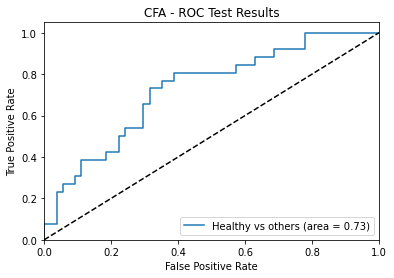

In [61]:
fpr_cfa, tpr_cfa, img_roc_auc_cfa = cal_img_roc(all_scores.reshape(all_scores.shape[0], -1).sum(axis=1), all_gts)
plt.plot(fpr_cfa, tpr_cfa, label='Healthy vs others (area = {0:0.2f})'
                                       ''.format(img_roc_auc_cfa))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# label ='AVG ROC = {0:0.2f}'''.format(totl_roc/3)
plt.title('CFA - ROC Test Results')
plt.legend(loc="lower right")

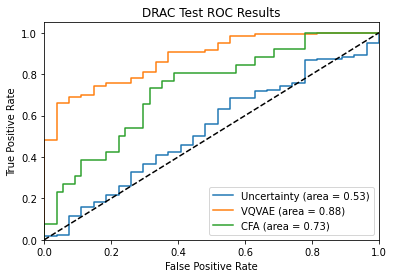

In [63]:
fpr_un, tpr_un, img_roc_auc_un = cal_img_roc(total_test, y_test_22)
plt.plot(fpr_un, tpr_un, label='Uncertainty (area = {0:0.2f})'
                                       ''.format(img_roc_auc_un))
fpr_vq, tpr_vq, img_roc_auc_vq = cal_img_roc(all_pred_tensor_test.cpu(), y_test_2)
plt.plot(fpr_vq, tpr_vq, label='VQVAE (area = {0:0.2f})'
                                       ''.format(img_roc_auc_vq))

fpr_vq, tpr_vq, img_roc_auc_vq = cal_img_roc(all_scores.reshape(all_scores.shape[0], -1).sum(axis=1), all_gts)
plt.plot(fpr_vq, tpr_vq, label='CFA (area = {0:0.2f})'
                                       ''.format(img_roc_auc_vq))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# label ='AVG ROC = {0:0.2f}'''.format(totl_roc/3)
plt.title('DRAC Test ROC Results')
plt.legend(loc="lower right")
plt.show()